# Lab 3: Gesture Recognition using Convolutional Neural Networks

In this lab you will train a convolutional neural network to make classifications on different hand gestures. By the end of the lab, you should be able to:

1. Load and split data for training, validation and testing
2. Train a Convolutional Neural Network
3. Apply transfer learning to improve your model

Note that for this lab we will not be providing you with any starter code. You should be able to take the code used in previous labs, tutorials and lectures and modify it accordingly to complete the tasks outlined below.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up
from parts 1-5. You can produce a PDF of your Google Colab file by
going to **File > Print** and then save as PDF. The Colab instructions
has more information. Make sure to review the PDF submission to ensure that your answers are easy to read. Make sure that your text is not cut off at the margins. 

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission. 

## Colab Link

Include a link to your colab file here

Colab Link: 

## Dataset

American Sign Language (ASL) is a complete, complex language that employs signs made by moving the
hands combined with facial expressions and postures of the body. It is the primary language of many
North Americans who are deaf and is one of several communication options used by people who are deaf or
hard-of-hearing. The hand gestures representing English alphabet are shown below. This lab focuses on classifying a subset
of these hand gesture images using convolutional neural networks. Specifically, given an image of a hand
showing one of the letters A-I, we want to detect which letter is being represented.

![alt text](https://www.disabled-world.com/pics/1/asl-alphabet.jpg)

## Part B. Building a CNN [50 pt]

For this lab, we are not going to give you any starter code. You will be writing a convolutional neural network
from scratch. You are welcome to use any code from previous labs, lectures and tutorials. You should also
write your own code.

You may use the PyTorch documentation freely. You might also find online tutorials helpful. However, all
code that you submit must be your own.

Make sure that your code is vectorized, and does not contain obvious inefficiencies (for example, unecessary
for loops, or unnecessary calls to unsqueeze()). Ensure enough comments are included in the code so that
your TA can understand what you are doing. It is your responsibility to show that you understand what you
write.

**This is much more challenging and time-consuming than the previous labs.** Make sure that you
give yourself plenty of time by starting early.

### 1. Data Loading and Splitting [5 pt]

Download the anonymized data provided on Quercus. To allow you to get a heads start on this project we will provide you with sample data from previous years. Split the data into training, validation, and test sets.

Note: Data splitting is not as trivial in this lab. We want our test set to closely resemble the setting in which
our model will be used. In particular, our test set should contain hands that are never seen in training!

Explain how you split the data, either by describing what you did, or by showing the code that you used.
Justify your choice of splitting strategy. How many training, validation, and test images do you have?

For loading the data, you can use plt.imread as in Lab 1, or any other method that you choose. You may find
torchvision.datasets.ImageFolder helpful. (see https://pytorch.org/docs/stable/torchvision/datasets.html?highlight=image%20folder#torchvision.datasets.ImageFolder
) 

In [8]:
import random
import os
import shutil
from sklearn.model_selection import train_test_split
from torchvision.datasets import ImageFolder

random.seed(42)

#Path to dataset
data_dir = '/Users/harrynguyen/Documents/GitHub/APS360/Labs/3/Lab3_Gestures_Summer'

#Get all individuals 
individuals = [name for name in os.listdir(data_dir) 
               if os.path.isdir(os.path.join(data_dir, name))]

#Split individuals into train, val, test sets 
#(30% random for combined validation and test set)
train_individuals, test_individuals = train_test_split(individuals, 
                                                       test_size=0.30, 
                                                       random_state=42)
#(50% random for validation and 50 for test set)
val_individuals, test_individuals = train_test_split(individuals, 
                                                     test_size=0.50, 
                                                     random_state=42)


#create directories for the splits
train_dir = '/Users/harrynguyen/Documents/GitHub/APS360/Labs/3/asl_train'
val_dir = '/Users/harrynguyen/Documents/GitHub/APS360/Labs/3/asl_val'
test_dir = '/Users/harrynguyen/Documents/GitHub/APS360/Labs/3/asl_test'

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

#Define a function to copy images to new directories
def copy_images(individuals, source_dir, dest_dir):
    for individual in individuals:
        individual_dir = os.path.join(source_dir, individual)
        if os.path.isdir(individual_dir):
            shutil.copytree(individual_dir, os.path.join(dest_dir, 
                                                         individual), 
                                                         dirs_exist_ok=True)

copy_images(train_individuals, data_dir, train_dir)
copy_images(val_individuals, data_dir, val_dir)
copy_images(test_individuals, data_dir, test_dir)

#Load dataset via ImageFolder
train_dataset = ImageFolder(train_dir)
val_dataset = ImageFolder(val_dir)
test_dataset = ImageFolder(test_dir)

#Check output of each set
print(f"Number of training images: ", len(train_dataset))
print(f"Number of validation images: ", len(val_dataset))
print(f"Number of test images: ", len(test_dataset))


'''
Justification for the splitting procedure

- There are two splits, the initial and the further splits. The initial split
ensures a clear separation between training data and the data used for 
validation and testing. The further split ensures that the data used for model 
evaluation and final performance assessement are distinct.

- Initial split comes at 70/30, in which 70% training and 30% combined 
validation and test. I believe 70% training would ensure enough data for 
learning without overfitting and the rest 30% would provide enough data 
for evaluation and tuning its hyperparameters. 

- During both the tuning and final evaluation phases, having the combined 
validation and test set equally split ensures a reliable peroformance metrics.

However, this is the initial guess and I'll document if any changes would 
be made.
'''



Number of training images:  1477
Number of validation images:  981
Number of test images:  1238


### 2. Model Building and Sanity Checking [15 pt]

### Part (a) Convolutional Network - 5 pt

Build a convolutional neural network model that takes the (224x224 RGB) image as input, and predicts the gesture
letter. Your model should be a subclass of nn.Module. Explain your choice of neural network architecture: how
many layers did you choose? What types of layers did you use? Were they fully-connected or convolutional?
What about other decisions like pooling layers, activation functions, number of channels / hidden units?

In [80]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ASLClassifier(nn.Module):
    def __init__(self, num_classes = 9):
        super(ASLClassifier, self).__init__()
        self.name = "ASLClassifier"

        # output (h and w) = (224 - 2*1 + 3) + 1 = 224 = input (h and w)

        #Convolutional layers (increasing numbers of filters)
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels=64, 
                               kernel_size = 3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels = 64, out_channels=128, 
                               kernel_size = 3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels = 128, out_channels=256, 
                               kernel_size = 3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels = 256, out_channels=512, 
                               kernel_size = 3, stride=1, padding=1)
        
        #Max-pooling layers 
        #reducing spatial dimensinons by half after each layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # 224/(2^4) = 14

        #Fully connected layers
        self.fc1 = nn.Linear(in_features=512 * 14 * 14, out_features=1024)
        self.fc2 = nn.Linear(in_features=1024, out_features=512)
        self.fc3 = nn.Linear(in_features=512, out_features=num_classes)

    def forward(self, x):
        #Convlutional layers with ReLU and pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))

        #Flatten the feature map
        x = x.view(-1, 512*14*14)

        #Fully connected layers with ReLU
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x) #handled by loss fuction 

        return x

model = ASLClassifier(num_classes=9)

'''
1. I chose 4 convolutional layers with increasing numbers of filters (64, 128
256, 512), as this helps in capturing various levels of abstraction

2. I chose 2 separately fully connected layers with 1024 and 512 hidden units,
respectively, allowing for learning combinations of the extracted featuers. 
The final fully connected layer maps these features to the output classes 
(gesture letters).

3. Pooling layers: reduce the spatial dimensions by half after each conv. layer

4. Activation function: ReLU activation functions introduce non-linearity, which
is crucial for learning such patterns. 

'''

'\n1. I chose 4 convolutional layers with increasing numbers of filters (64, 128\n256, 512), as this helps in capturing various levels of abstraction\n\n2. I chose 2 separately fully connected layers with 1024 and 512 hidden units,\nrespectively, allowing for learning combinations of the extracted featuers. \nThe final fully connected layer maps these features to the output classes \n(gesture letters).\n\n3. Pooling layers: reduce the spatial dimensions by half after each conv. layer\n\n4. Activation function: ReLU activation functions introduce non-linearity, which\nis crucial for learning such patterns. \n\n'

### Part (b) Training Code - 5 pt

Write code that trains your neural network given some training data. Your training code should make it easy
to tweak the usual hyperparameters, like batch size, learning rate, and the model object itself. Make sure
that you are checkpointing your models from time to time (the frequency is up to you). Explain your choice
of loss function and optimizer.

In [33]:
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
import torch.optim as optim
import numpy as np
import time
from torch.utils.data.sampler import SubsetRandomSampler

### Helper Functions (Inspired from Lab 2)

In [107]:
###############################################################################
# Data Loading

def get_relevant_indices(dataset, classes, target_classes):
    """ Return the indices for datapoints in the dataset that belongs to the
    desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of desired classes
                        Should be a subset of the 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    indices = []
    for i in range(len(dataset)):
        # Check if the label is in the target classes
        label_index = dataset[i][1] # ex: 3
        label_class = classes[label_index] # ex: 'cat'
        if label_class in target_classes:
            indices.append(i)
    return indices

def get_data_loader(target_classes, batch_size):
    """ Loads images of cats and dogs, splits the data into training, validation
    and testing datasets. Returns data loaders for the three preprocessed datasets.

    Args:
        target_classes: A list of strings denoting the name of the desired
                        classes. Should be a subset of the argument 'classes'
        batch_size: A int representing the number of samples per batch
    
    Returns:
        train_loader: iterable training dataset organized according to batch size
        val_loader: iterable validation dataset organized according to batch size
        test_loader: iterable testing dataset organized according to batch size
        classes: A list of strings denoting the name of each class
    """

    classes = ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I')
    ########################################################################
    # The output of torchvision datasets are PILImage images of range [0, 1].
    # We transform them to Tensors of normalized range [-1, 1].
    transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
         transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
    # Load training data
    trainset = datasets.ImageFolder('/Users/harrynguyen/Documents/GitHub/APS360/Labs/3/asl_train',
                                    transform=transform)
    # Get the list of indices to sample from
    relevant_indices = get_relevant_indices(trainset, classes, target_classes)
    
    # Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(relevant_indices)
    split = int(len(relevant_indices) * 0.8) #split at 80%
    
    # split into training and validation indices
    relevant_train_indices, relevant_val_indices = relevant_indices[:split], relevant_indices[split:]  
    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)
    # Load testing data
    testset = datasets.ImageFolder('/Users/harrynguyen/Documents/GitHub/APS360/Labs/3/asl_test',
                                   transform=transform)
    # Get the list of indices to sample from
    relevant_test_indices = get_relevant_indices(testset, classes, target_classes)
    test_sampler = SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             num_workers=1, sampler=test_sampler)
    return train_loader, val_loader, test_loader, classes

###############################################################################
# Training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = ((labels - min_val)/(max_val - min_val))
    return norm_labels

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    net.eval()
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    with torch.no_grad():
        for data in loader:
            inputs, labels = data
            labels = normalize_label(labels)
            labels = labels.long() 
            outputs = net(inputs)
            loss = criterion(outputs, labels.float())
            corr = (outputs.argmax(dim=1) != labels).sum().item()
            total_err += corr
            total_loss += loss.item()
            total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / len(loader)
    return err, loss

def save_files(model_name, batch_size, learning_rate, epoch, checkpoint_dir, 
               train_err, train_loss, val_err=None, val_loss=None):
    """
    Saves training and optionally validation error and loss to CSV files.

    Args:
        model_name (str): Name of the model.
        batch_size (int): Batch size used during training.
        learning_rate (float): Learning rate used during training.
        epoch (int): Current epoch number.
        checkpoint_dir (str): Directory to save the checkpoint files.
        train_err (np.array): Array of training errors.
        train_loss (np.array): Array of training losses.
        val_err (np.array, optional): Array of validation errors.
        val_loss (np.array, optional): Array of validation losses.
    """
    model_path = get_model_name(model_name, batch_size, learning_rate, epoch)
    
    train_err_path = os.path.join(checkpoint_dir, f"{model_path}_train_err.csv")
    train_loss_path = os.path.join(checkpoint_dir, f"{model_path}_train_loss.csv")
    np.savetxt(train_err_path, train_err, delimiter=',')
    np.savetxt(train_loss_path, train_loss, delimiter=',')
    
    if val_err is not None and val_loss is not None:
        val_err_path = os.path.join(checkpoint_dir, f"{model_path}_val_err.csv")
        val_loss_path = os.path.join(checkpoint_dir, f"{model_path}_val_loss.csv")
        np.savetxt(val_err_path, val_err, delimiter=',')
        np.savetxt(val_loss_path, val_loss, delimiter=',')

###############################################################################
# Training Curve
def plot_training_curve(path, checkpoint_dir, smalldata = False):
    import matplotlib.pyplot as plt
    train_err_path = os.path.join(checkpoint_dir, f"{path}_train_err.csv")
    train_loss_path = os.path.join(checkpoint_dir, f"{path}_train_loss.csv")
    train_err = np.loadtxt(train_err_path, delimiter= ',')
    train_loss = np.loadtxt(train_loss_path, delimiter= ',')
    if not smalldata:
        val_err_path = os.path.join(checkpoint_dir, f"{path}_val_err.csv")
        val_loss_path = os.path.join(checkpoint_dir, f"{path}_val_loss.csv")
        val_err = np.loadtxt(val_err_path, delimiter= ',')
        val_loss = np.loadtxt(val_loss_path, delimiter= ',')
        plt.title("Train vs Validation Error")
        n = len(train_err) # number of epochs
        plt.plot(range(1,n+1), train_err, label="Train")
        plt.plot(range(1,n+1), val_err, label="Validation")
        plt.xlabel("Epoch")
        plt.ylabel("Error")
        plt.legend(loc='best')
        plt.show()

        plt.title("Train vs Validation Loss")
        plt.plot(range(1,n+1), train_loss, label="Train")
        plt.plot(range(1,n+1), val_loss, label="Validation")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend(loc='best')
        plt.show()
    else:
        plt.title("Train Error and Train Loss")
        n = len(train_err)
        plt.plot(range(1,n+1), train_err, label="Train Error")
        plt.plot(range(1,n+1), train_loss, label="Train Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Value Ratio")
        plt.legend(loc='best')
        plt.show()

In [108]:
def train_model(net, batch_size, learning_rate, num_epochs, checkpoint_frequency):
    torch.manual_seed(1000)

    train_loader, val_loader, test_loader, classes = get_data_loader(
            target_classes=["A", "B", "C", "D", "E", "F", "G", "H", "I"], batch_size=batch_size)
    
    # Define the Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    
    # Create directories for checkpoints if they don't exist
    checkpoint_dir = '/Users/harrynguyen/Documents/GitHub/APS360/Labs/3/model_checkpoint'
    os.makedirs(checkpoint_dir, exist_ok=True)

    start_time = time.time()
    net.train()
    for epoch in range(num_epochs):
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            labels = labels.long()  # Convert labels to the required format
            
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            corr = (outputs.argmax(dim=1) != labels).sum().item()
            total_train_err += corr
            total_train_loss += loss.item()
            total_epoch += len(labels)
        
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i + 1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        
        # Save checkpoint
        if (epoch + 1) % checkpoint_frequency == 0:
            save_files(net.name, batch_size, learning_rate, epoch, checkpoint_dir,
                       train_err, train_loss, val_err, val_loss)
            print(f"Model checkpoint saved at {epoch + 1}th epoch")
    
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Total time elapsed: {elapsed_time:.2f} seconds")
    
    # # Save metrics to CSV
    # epochs = np.arange(1, num_epochs + 1)
    # np.savetxt(f"{checkpoint_dir}/train_err.csv", train_err, delimiter=',')
    # np.savetxt(f"{checkpoint_dir}/train_loss.csv", train_loss, delimiter=',')
    # np.savetxt(f"{checkpoint_dir}/val_err.csv", val_err, delimiter=',')
    # np.savetxt(f"{checkpoint_dir}/val_loss.csv", val_loss, delimiter=',')
    
    return net, train_err, train_loss, val_err, val_loss


'''
Choice of Loss Function: Cross-Entroypy Loss
--> Chosen for its suitability for multi-class classification tasks,
providing a measure of how well the predicted probabilities match 
the true class labels

Choice of Optimizer: Adam
--> Chosen for its adaptive learning rate, combining the benefits of 
AdaGrad and RMSProp, making it effective and efficient for training neural
networks'''

'\nChoice of Loss Function: Cross-Entroypy Loss\n--> Chosen for its suitability for multi-class classification tasks,\nproviding a measure of how well the predicted probabilities match \nthe true class labels\n\nChoice of Optimizer: Adam\n--> Chosen for its adaptive learning rate, combining the benefits of \nAdaGrad and RMSProp, making it effective and efficient for training neural\nnetworks'

### Part (c) “Overfit” to a Small Dataset - 5 pt

One way to sanity check our neural network model and training code is to check whether the model is capable
of “overfitting” or “memorizing” a small dataset. A properly constructed CNN with correct training code
should be able to memorize the answers to a small number of images quickly.

Construct a small dataset (e.g. just the images that you have collected). Then show that your model and
training code is capable of memorizing the labels of this small data set.

With a large batch size (e.g. the entire small dataset) and learning rate that is not too high, You should be
able to obtain a 100% training accuracy on that small dataset relatively quickly (within 200 iterations).

In [82]:
def get_small_data_loader(batch_size):
    classes = ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I')

    transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    #Loadd small dataset
    small_dataset = datasets.ImageFolder('/Users/harrynguyen/Documents/GitHub/APS360/Labs/3/small_dataset',
                                         transform=transform)
    small_loader = torch.utils.data.DataLoader(small_dataset, 
                                               batch_size=batch_size, 
                                               shuffle=True,
                                                num_workers=1)
    return small_loader, classes

In [83]:
def train_on_small_dataset(net, batch_size = 8, learning_rate=0.001, num_epochs=20):
    # Fixed PyTorch random seed for reproducibility
    torch.manual_seed(1000)
    
    # Obtain the small dataset loader
    small_loader, classes = get_small_data_loader(batch_size=batch_size)
    
    # Define the Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)

    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    
    checkpoint_dir = '/Users/harrynguyen/Documents/GitHub/APS360/Labs/3/small_checkpoint'
    os.makedirs(checkpoint_dir, exist_ok=True)

    net.train()
    for epoch in range(num_epochs):
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        
        for i, data in enumerate(small_loader, 0):
            inputs, labels = data
            labels = labels.long()  # Convert labels to Long type
            
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            corr = (outputs.argmax(dim=1) != labels).sum().item()
            total_train_err += corr
            total_train_loss += loss.item()
            total_epoch += len(labels)
        
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i + 1)
        
        print(f"Epoch {epoch + 1}: Train err: {train_err[epoch]}, Train loss: {train_loss[epoch]}")
        
        # Check if training error is zero (i.e., model has overfitted)
        if train_err[epoch] == 0.0:
            print(f"Model has memorized the dataset in {epoch + 1} epochs.")
            break
    
        # model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        # torch.save(net.state_dict(), model_path)
    print('Finished Training on Small Dataset')

    #Save metrics to CSV
    model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
    train_err_path = os.path.join(checkpoint_dir, f"{model_path}_train_err.csv")
    train_loss_path = os.path.join(checkpoint_dir, f"{model_path}_train_loss.csv")
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt(train_err_path, train_err, delimiter= ',')
    np.savetxt(train_loss_path, train_loss, delimiter= ',')

    return net, train_err, train_loss


# Example of how to call train_on_small_dataset
# Assume net is an instance of the ASLClassifier model
# train_on_small_dataset(net)


In [91]:
small_model = ASLClassifier()
small_model, train_err, train_loss = train_on_small_dataset(small_model)


Epoch 1: Train err: 0.8888888888888888, Train loss: 2.5234713554382324
Epoch 2: Train err: 0.8888888888888888, Train loss: 2.2069159348805747
Epoch 3: Train err: 0.9111111111111111, Train loss: 2.1965991059939065
Epoch 4: Train err: 0.8222222222222222, Train loss: 2.063323676586151
Epoch 5: Train err: 0.6444444444444445, Train loss: 1.8076063593228657
Epoch 6: Train err: 0.45555555555555555, Train loss: 1.3915549019972484
Epoch 7: Train err: 0.28888888888888886, Train loss: 1.3775867174069087
Epoch 8: Train err: 0.3, Train loss: 0.7074908781796694
Epoch 9: Train err: 0.28888888888888886, Train loss: 0.7543661370873451
Epoch 10: Train err: 0.15555555555555556, Train loss: 0.3971026645352443
Epoch 11: Train err: 0.13333333333333333, Train loss: 0.31333390654375154
Epoch 12: Train err: 0.06666666666666667, Train loss: 0.15863611735403538
Epoch 13: Train err: 0.03333333333333333, Train loss: 0.07195909054280492
Epoch 14: Train err: 0.07777777777777778, Train loss: 0.5381678578123683
Epoch 

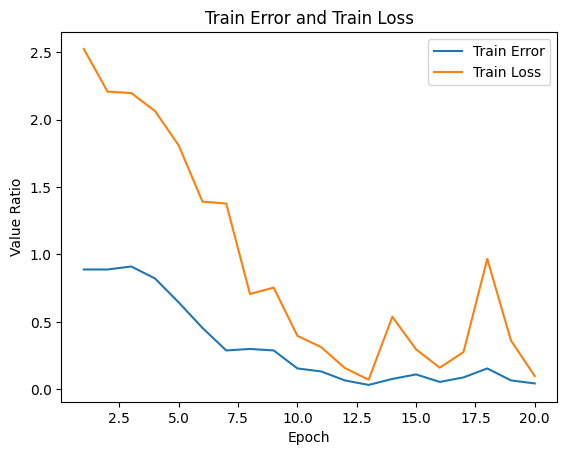

In [92]:
small_model_path = get_model_name(small_model.name, 8, 0.001, 19)
checkpoint_dir = '/Users/harrynguyen/Documents/GitHub/APS360/Labs/3/small_checkpoint'
plot_training_curve(small_model_path, checkpoint_dir, smalldata=True)

### 3. Hyperparameter Search [15 pt]

### Part (a) - 3 pt

List 3 hyperparameters that you think are most worth tuning. Choose at least one hyperparameter related to
the model architecture.

In [ ]:
'''
3 hyperpameters that I think are most worth tuning are:
- Learning Rate: determines the size of the steps taken during gradient
                 descent to minimize loss function. Tuning range is 
                 between 10^-3 to 10^-1.
- Batch Size:    defines the number of samples that will be propagated
                 through the network at one time. Common values (used
                 for tuning) are 16, 32, 64, 128, etc.
- Number of Filters in Convolutional Layers: 
                 This hyperparameter is related to the model architecture.
                 It affects the capacity of the network to learn different 
                 features from the input data. Common values are the power
                 of 2, such as 32, 64, 128, etc.
'''

### Part (b) - 5 pt

Tune the hyperparameters you listed in Part (a), trying as many values as you need to until you feel satisfied
that you are getting a good model. Plot the training curve of at least 4 different hyperparameter settings.

In [99]:
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
import numpy as np
import os

# Function to train and evaluate the model
def train_and_evaluate_model(learning_rate, batch_size, num_filters, epochs, checkpoint_frequency):
    class CustomASLClassifier(nn.Module):
        def __init__(self, num_classes=9):
            super(CustomASLClassifier, self).__init__()
            self.conv1 = nn.Conv2d(3, num_filters, kernel_size=3, stride=1, padding=1)
            self.conv2 = nn.Conv2d(num_filters, num_filters*2, kernel_size=3, stride=1, padding=1)
            self.conv3 = nn.Conv2d(num_filters*2, num_filters*4, kernel_size=3, stride=1, padding=1)
            self.conv4 = nn.Conv2d(num_filters*4, num_filters*8, kernel_size=3, stride=1, padding=1)
            self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
            self.fc1 = nn.Linear(num_filters*8 * 14 * 14, 1024)
            self.fc2 = nn.Linear(1024, 512)
            self.fc3 = nn.Linear(512, num_classes)
        
        def forward(self, x):
            x = self.pool(F.relu(self.conv1(x)))
            x = self.pool(F.relu(self.conv2(x)))
            x = self.pool(F.relu(self.conv3(x)))
            x = self.pool(F.relu(self.conv4(x)))
            x = x.view(-1, num_filters*8 * 14 * 14)
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = self.fc3(x)
            return x

    # Initialize model, train and evaluate
    model = CustomASLClassifier()
    train_err, train_loss, val_err, val_loss = train_model(model, batch_size, learning_rate, epochs, 
                                                           checkpoint_frequency)
    
    return train_err, train_loss, val_err, val_loss




In [109]:
# Hyperparameter settings to try
hyperparams = [
    {'learning_rate': 0.001, 'batch_size': 32, 'num_filters': 32},
    {'learning_rate': 0.001, 'batch_size': 64, 'num_filters': 64},
    {'learning_rate': 0.01, 'batch_size': 64, 'num_filters': 64},
    {'learning_rate': 0.01, 'batch_size': 128, 'num_filters': 128},
]

results = []

# Train and evaluate models with different hyperparameter settings
for params in hyperparams:
    train_err, train_loss, val_err, val_loss = train_and_evaluate_model(
        params['learning_rate'], params['batch_size'], params['num_filters'],
        epochs=20, checkpoint_frequency=5)
    results.append({
        'params': params,
        'train_err': train_err,
        'train_loss': train_loss,
        'val_err': val_err,
        'val_loss': val_loss
    })

RuntimeError: expected scalar type Long but found Float

In [ ]:
# Plotting the results
for result in results:
    params = result['params']
    train_err = result['train_err']
    train_loss = result['train_loss']
    val_err = result['val_err']
    val_loss = result['val_loss']
    
    epochs = np.arange(1, len(train_err) + 1)
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Learning Rate: {params["learning_rate"]}, Batch Size: {params["batch_size"]}, Filters: {params["num_filters"]}')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_err, label='Train Error')
    plt.plot(epochs, val_err, label='Validation Error')
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.title(f'Learning Rate: {params["learning_rate"]}, Batch Size: {params["batch_size"]}, Filters: {params["num_filters"]}')
    plt.legend()
    
    plt.show()

### Part (c) - 3 pt
Choose the best model out of all the ones that you have trained. Justify your choice.

### Part (d) - 4 pt
Report the test accuracy of your best model. You should only do this step once and prior to this step you should have only used the training and validation data.

### 4. Transfer Learning [15 pt]
For many image classification tasks, it is generally not a good idea to train a very large deep neural network
model from scratch due to the enormous compute requirements and lack of sufficient amounts of training
data.

One of the better options is to try using an existing model that performs a similar task to the one you need
to solve. This method of utilizing a pre-trained network for other similar tasks is broadly termed **Transfer
Learning**. In this assignment, we will use Transfer Learning to extract features from the hand gesture
images. Then, train a smaller network to use these features as input and classify the hand gestures.

As you have learned from the CNN lecture, convolution layers extract various features from the images which
get utilized by the fully connected layers for correct classification. AlexNet architecture played a pivotal
role in establishing Deep Neural Nets as a go-to tool for image classification problems and we will use an
ImageNet pre-trained AlexNet model to extract features in this assignment.

### Part (a) - 5 pt
Here is the code to load the AlexNet network, with pretrained weights. When you first run the code, PyTorch
will download the pretrained weights from the internet.

In [112]:
import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)
alexnet.eval()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /Users/harrynguyen/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100.0%


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

The alexnet model is split up into two components: *alexnet.features* and *alexnet.classifier*. The
first neural network component, *alexnet.features*, is used to compute convolutional features, which are
taken as input in *alexnet.classifier*.

The neural network alexnet.features expects an image tensor of shape Nx3x224x224 as input and it will
output a tensor of shape Nx256x6x6 . (N = batch size).

Compute the AlexNet features for each of your training, validation, and test data. Here is an example code
snippet showing how you can compute the AlexNet features for some images (your actual code might be
different):

In [118]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

# Define the transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load the datasets
train_dataset = datasets.ImageFolder('/Users/harrynguyen/Documents/GitHub/APS360/Labs/3/asl_train', transform=transform)
val_dataset = datasets.ImageFolder('/Users/harrynguyen/Documents/GitHub/APS360/Labs/3/asl_val', transform=transform)
test_dataset = datasets.ImageFolder('/Users/harrynguyen/Documents/GitHub/APS360/Labs/3/asl_test', transform=transform)

# Define the data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)



**Save the computed features**. You will be using these features as input to your neural network in Part
(b), and you do not want to re-compute the features every time. Instead, run *alexnet.features* once for
each image, and save the result.

In [113]:
def extract_and_save_features(dataloader, model, feature_file, label_file):
    features = []
    labels = []
    with torch.no_grad():
        for inputs, targets in dataloader:
            outputs = model.features(inputs)
            features.append(outputs)
            labels.append(targets)
    features = torch.cat(features)
    labels = torch.cat(labels)
    torch.save(features, feature_file)
    torch.save(labels, label_file)

# Extract and save features for each dataset
extract_and_save_features(train_loader, alexnet, 'train_features.pt', 'train_labels.pt')
extract_and_save_features(val_loader, alexnet, 'val_features.pt', 'val_labels.pt')
extract_and_save_features(test_loader, alexnet, 'test_features.pt', 'test_labels.pt')

### Part (b) - 3 pt
Build a convolutional neural network model that takes as input these AlexNet features, and makes a
prediction. Your model should be a subclass of nn.Module.

Explain your choice of neural network architecture: how many layers did you choose? What types of layers
did you use: fully-connected or convolutional? What about other decisions like pooling layers, activation
functions, number of channels / hidden units in each layer?

Here is an example of how your model may be called:

In [127]:
import torch.nn as nn
import torch.nn.functional as F

class AlexNetFeatureClassifier(nn.Module):
    def __init__(self, num_classes=9):
        super(AlexNetFeatureClassifier, self).__init__()
        self.fc1 = nn.Linear(3*224*224, 256*6*6)
        self.fc2 = nn.Linear(256*6*6,1024)
        self.fc3 = nn.Linear(1024, num_classes)
    
    def forward(self, x):
        print(f"Input shape before flattening: {x.shape}")
        x = x.view(x.size(0), -1)  # Flatten the tensor
        print(f"Shape after flattening: {x.shape}")
        x = F.relu(self.fc1(x))    # First fully connected layer with ReLU
        x = F.relu(self.fc2(x))    # Second fully connected layer
        x = self.fc3(x)            
        return x

# Example usage:
# features = ...  # Load precomputed AlexNet features
# model = AlexNetFeatureClassifier(num_classes=9)
# output = model(features)
# prob = F.softmax(output, dim=1)

'''
Explanation of Choices:

Fully Connected Layers:
 - First Fully Connected Layer: Reduces the dimensionality 
from 9216 (256 * 6 * 6) to 1024. This layer helps in 
learning complex representations of the input features.
 - Second Fully Connected Layer: Maps the 1024 features 
 to the number of classes (9). This layer provides the 
 final output logits for classification.

Activation Function (ReLU):
- ReLU is used after the first fully connected layer 
 to introduce non-linearity. This activation function 
 helps the model learn complex patterns and prevents issues 
 related to vanishing gradients.

Flattening the Input:
 - The input features from AlexNet are in the shape 
 [N, 256, 6, 6]. Before feeding them into the fully 
 connected layers, we flatten these features to a 1D 
 tensor of size 9216 (256 * 6 * 6).

Softmax Function:
 - Although not included in the model definition, the 
 softmax function is applied to the output logits to get 
 the probability distribution over the classes. This is 
 useful for interpreting the model's predictions.
'''


"\nExplanation of Choices:\n\nFully Connected Layers:\n - First Fully Connected Layer: Reduces the dimensionality \nfrom 9216 (256 * 6 * 6) to 1024. This layer helps in \nlearning complex representations of the input features.\n - Second Fully Connected Layer: Maps the 1024 features \n to the number of classes (9). This layer provides the \n final output logits for classification.\n\nActivation Function (ReLU):\n- ReLU is used after the first fully connected layer \n to introduce non-linearity. This activation function \n helps the model learn complex patterns and prevents issues \n related to vanishing gradients.\n\nFlattening the Input:\n - The input features from AlexNet are in the shape \n [N, 256, 6, 6]. Before feeding them into the fully \n connected layers, we flatten these features to a 1D \n tensor of size 9216 (256 * 6 * 6).\n\nSoftmax Function:\n - Although not included in the model definition, the \n softmax function is applied to the output logits to get \n the probability

### Part (c) - 5 pt
Train your new network, including any hyperparameter tuning. Plot and submit the training curve of your
best model only.

Note: Depending on how you are caching (saving) your AlexNet features, PyTorch might still be tracking
updates to the **AlexNet weights**, which we are not tuning. One workaround is to convert your AlexNet
feature tensor into a numpy array, and then back into a PyTorch tensor.

In [115]:
# Load the precomputed features and labels
train_features = torch.load('train_features.pt')
train_labels = torch.load('train_labels.pt')
val_features = torch.load('val_features.pt')
val_labels = torch.load('val_labels.pt')
test_features = torch.load('test_features.pt')
test_labels = torch.load('test_labels.pt')


In [116]:
def convert_to_tensor(tensor):
    return torch.from_numpy(tensor.detach().numpy())

train_features = convert_to_tensor(train_features)
train_labels = convert_to_tensor(train_labels)
val_features = convert_to_tensor(val_features)
val_labels = convert_to_tensor(val_labels)
test_features = convert_to_tensor(test_features)
test_labels = convert_to_tensor(test_labels)


In [119]:
from torch.utils.data import TensorDataset

# Create TensorDatasets
train_dataset = TensorDataset(train_features, train_labels)
val_dataset = TensorDataset(val_features, val_labels)
test_dataset = TensorDataset(test_features, test_labels)

#Data Loader already defined


In [128]:
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

def train_model_alex(net, train_loader, val_loader, num_epochs, learning_rate):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    
    train_losses = []
    val_losses = []
    
    net.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        
        net.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
        
        epoch_val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)
        
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}')
    
    return train_losses, val_losses

# Initialize and train the model
model = AlexNetFeatureClassifier(num_classes=9)
train_losses, val_losses = train_model_alex(model, train_loader, val_loader, num_epochs=30, learning_rate=0.001)

# Plot the training curve
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Curve')
plt.show()


Input shape before flattening: torch.Size([64, 3, 224, 224])
Shape after flattening: torch.Size([64, 150528])


: 

### Part (d) - 2 pt
Report the test accuracy of your best model. How does the test accuracy compare to Part 3(d) without transfer learning?